In [40]:
# imports
import pandas as p
import constants as c
import folium
import os
import zipfile
from collections import Counter
import math
import matplotlib.pyplot as plt
import statistics as stats
import haversine as hs
from datetime import datetime


# constants
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957
FOLDER_PATH = "../dataset/2019_01/"
SPEED_THRESHOLD = 1

Extract only the data with the correct latitude and longitude values
This operation takes roughly 15-20 seconds per csv file (tested on csv files with > 1 million rows)

In [17]:
final_df = p.DataFrame()

# list all the files in the specified directory
filenames = os.listdir(FOLDER_PATH)
# and sort them alphabetically
filenames.sort()
# for each file
for file_name in filenames:
    # only iterate over zip files
    if file_name.endswith('.zip'):
        file_path = os.path.join(FOLDER_PATH, file_name)
        # if the csv file has yet to be extracted
        csv_filename = file_name.replace(".zip", ".csv")
        if not(os.path.exists(os.path.join(FOLDER_PATH, csv_filename))):
            # open the zip file and extract it
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                csv_filename = zip_file.namelist()[0]
                zip_file.extractall(FOLDER_PATH)
        # create a dataframe using the extracted csv file
        full_df = p.read_csv(os.path.join(FOLDER_PATH, csv_filename))
        # extract only the rows of interest (with LAT and LON values between the specified bounds)
        filtered_df = full_df[
                                (full_df['LAT'].between(LAT_MIN, LAT_MAX)) &
                                (full_df['LON'].between(LON_MIN, LON_MAX)) 
                            ]
        # and append the extracted rows to the final dataframe
        final_df = p.concat([final_df, filtered_df], ignore_index = True)

print(f"Final dataframe len: {final_df.shape[0]}")
print(final_df.head())
      
    

        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338070127  2019-01-01T00:00:02  21.31311 -157.86715  0.0  190.3    511.0   
1  367379890  2019-01-01T00:00:01  21.28031 -157.83826  1.5   36.7    511.0   
2  367119160  2019-01-01T00:00:02  21.31010 -157.86773  0.1  329.0    159.0   
3  367008740  2019-01-01T00:00:02  21.30887 -157.87032  0.0   21.4    511.0   
4  367213090  2019-01-01T00:00:04  21.95327 -159.35876  0.0  196.1    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   HONOLULU         NaN      NaN        50.0     NaN    12.0    4.0    NaN   
1  DISCOVERY         NaN  WCC5846        60.0     0.0    23.0    7.0    NaN   
2   HOKULANI  IMO7417422  WDI9073        31.0     0.0    34.0   10.0    4.9   
3  MIKI HANA  IMO7031163  WTW9252        31.0     0.0    33.0    9.0    3.9   
4        NaN         NaN      NaN         NaN     0.0     NaN    NaN    NaN   

   Cargo TransceiverClass  
0    NaN              

Separate code snippet used for exporting the final dataframe as a csv file.
This is necessary as the above code snippet takes ~8 minutes read and filter 31 csv files.
By exporting the resulting df as a csv file it's possible import it again for the following part of this notebook

In [2]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = FOLDER_PATH
FILE_NAME = '2019_01.csv' #specify file name (don't forget the .csv extension)
#final_df.to_csv(OUTPUT_PATH + '/' + FILE_NAME, index = False)

#print(f"Final dataframe len: {final_df.shape[0]}")


Read the csv file and use it as the final data source
(The code snippet below should be used only if the code snippet #2 was not executed)

In [3]:
# read csv
final_df = p.read_csv(OUTPUT_PATH + FILE_NAME)
final_df.drop_duplicates(keep='first') # drop duplicates
final_df.BaseDateTime = p.to_datetime(final_df.BaseDateTime) # Convert DateTime into more readable format

print(f"Final dataframe len: {final_df.shape[0]}")

Final dataframe len: 1924660


Some stats about the imported dataframe
In order to make the histogram below, occurrencies are rounded to the top hundred (ex: 33 -> 100, 244 -> 300, etc...)
This is done in order to have an idea about how many ships have negligible amount of records.
In the next code snippet (#10) the threshold is set to 100 and consequently all vessels with less than 100 data points are removed from the dataset

Num of rows: 1924660
Num of vessels: 423
Avg entries for each vessel 4550.023640661939
Variance: 37102188.6108142
Standard Deviation: 6091.156590567525
Max entries found for the same ship: 28673
Min entries found for the same ship: 1
Final dataframe len: 1924660, num of vessels: 423


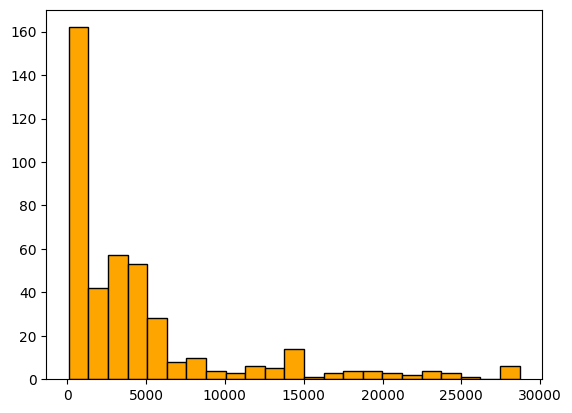

In [4]:
# Number of entries (number of rows of the dataframe)
num_of_rows = final_df.index.shape[0]
print("Num of rows: " + str(num_of_rows))

# Extract all the unique MMSIs
unique_vessels_ids = p.unique(final_df['MMSI']).tolist()
num_of_vessels = len(unique_vessels_ids)
print("Num of vessels: " + str(num_of_vessels))

# Calculate the exact number of entries for each ship
vessels_entries_dict = dict(Counter(final_df['MMSI'].to_list())) # save it in a dict
vessels_entries = list(vessels_entries_dict.values()) # save just the values in a list
vessels_entries.sort()
rounded_vessels_entries = [math.ceil(x/100) * 100 for x in vessels_entries]

print(f"Avg entries for each vessel {stats.mean(vessels_entries)}")
print(f"Variance: {stats.variance(vessels_entries)}")
print(f"Standard Deviation: {stats.stdev(vessels_entries)}")
print(f"Max entries found for the same ship: {vessels_entries[-1]}")
print(f"Min entries found for the same ship: {vessels_entries[0]}")

n, bins, patches = plt.hist(x=rounded_vessels_entries, bins='auto', color='orange', edgecolor = 'black')


print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessels_entries)}")

Remove ships with not enough entries

In [62]:
THRESHOLD = 100

mmsi_to_be_removed = [x for x in vessels_entries_dict.keys() if vessels_entries_dict[x] <= THRESHOLD]
print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessels_entries)}, unwanted vessels: {len(mmsi_to_be_removed)}")
clean_df = final_df.copy()

for unwanted_mmsi in mmsi_to_be_removed:
    clean_df = clean_df.drop(clean_df[clean_df['MMSI'] == unwanted_mmsi].index)

clean_df.drop_duplicates(keep='first', inplace=True)

print(f"Cleaned dataframe len: {clean_df.shape[0]}, num of vessels: {len(p.unique(clean_df['MMSI']))}")

Final dataframe len: 1924660, num of vessels: 423, unwanted vessels: 71
Final dataframe len: 1924660, num of vessels: 423, unwanted vessels: 71
Cleaned dataframe len: 1922770, num of vessels: 352


Export the cleaned dataframe in order to have a backup copy in a csv file

In [6]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = FOLDER_PATH
FILE_NAME = 'cleaned_2019_01.csv' #specify file name (don't forget the .csv extension)
clean_df.to_csv(OUTPUT_PATH + '/' + FILE_NAME, index = False)

#print(f"Final dataframe len: {final_df.shape[0]}")

Create a new histogram using the "cleaned" data from the clean_df

Avg entries for each vessel 5463.980113636364
Variance: 39616279.979660384
Standard Deviation: 6294.146485398984
Max entries found for the same ship: 28673
Min entries found for the same ship: 105


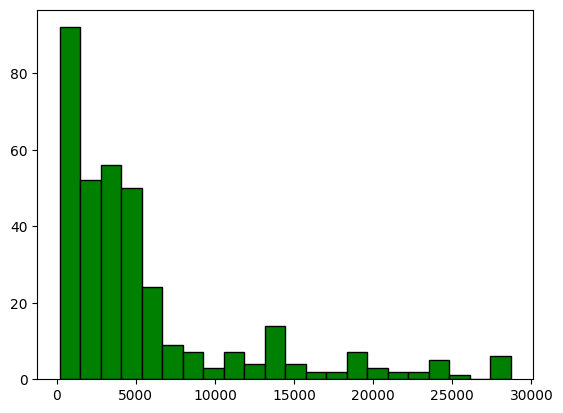

In [7]:
clean_vessel_entries = list(Counter(clean_df['MMSI'].to_list()).values())

rounded_clean_vessels_entries = [math.ceil(x/100) * 100 for x in clean_vessel_entries]

print(f"Avg entries for each vessel {stats.mean(clean_vessel_entries)}")
print(f"Variance: {stats.variance(clean_vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(clean_vessel_entries)}")
print(f"Max entries found for the same ship: {max(clean_vessel_entries)}")
print(f"Min entries found for the same ship: {min(clean_vessel_entries)}")

n, bins, patches = plt.hist(x=rounded_clean_vessels_entries, bins='auto', color='green', edgecolor = 'black', )

Print a few points on the map just to check that everything works

In [ ]:
map = folium.Map(location=[21, -158], tiles="OpenStreetMap", zoom_start=9)

clean_df.sort_values(by='MMSI', inplace=True)

#test ranges (replace x and y below): [2:474], [474, 1364], [1364,1837], [1837:2285], [2285, 2725]
x = 2
y = 30000
# extract from the dataset latitude and longitude of the values in range [x:y)
loc = [[str(mmsi), lat, lon] for (mmsi, lat, lon) in zip(clean_df.iloc[x:y]['MMSI'], clean_df.iloc[x:y]['LAT'], clean_df.iloc[x:y]['LON'])]

tempDF = p.DataFrame(loc)
tempDF.columns = ['MMSI', 'LAT', 'LON'] # create a temporary df with the extracted mmsi, lat. and long. values

# CircleMarker requires each point to be added one by one
# The temp function below is applied to all points in the tempDF
def tempFunc(row):
    folium.CircleMarker(
        location=[row['LAT'],row['LON']],
        radius=0.5
        ).add_child(folium.Popup(row['MMSI'])).add_to(map)

# Using 'apply' with a custom function saves a bit of time (compared to a simple for-loop)
tempDF.apply(tempFunc, axis=1)

map 

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

Function "Online_WP_Clustering"<br>
Takes as input:<br>
   - Vs: list of vessels<br>
   - v: vessel that generated the event of interest to be clustered<br>
   - WPs: list of waypoints to be clustered (list of entri, stationary and exit points)<br>
   - Rs: list of routes to be modified<br>
   - Eps: radius of the cluster for the DBSCAN algorithm<br>
   - N: minimum number of points for each cluster for the DBSCAN algorithm<br>
   
Returns:<br>
   - WPs
   - v
   - Rs

In [ ]:

def Online_WP_Clustering(WPs, Rs, Vs, Eps, N, v) -> list:
    None

Function "Route_Objects_Manager"<br>
Takes as input:<br>
   - v: vessel that generated the event of interest to be clustered<br>
   - WPs: list of waypoints to be clustered (list of entry, stationary and exit points)<br>
   - Rs: list of routes to be modified<br>

Returns:<br>
   - v
   - Rs

In [ ]:
def Route_Objects_Manager(Rs, Vs, v) -> list:
    None

In [63]:
Vs = {} # Dictionary used for storing vessels during the operations of the algorithm

test_df = clean_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'COG', 'SOG']].head(200).copy()

for i in test_df.index:
    mmsi = test_df['MMSI'][i]
    timestamp = test_df['BaseDateTime'][i]
    lat = test_df['LAT'][i]
    lon = test_df['LON'][i]
    cog = test_df['COG'][i]
    sog = test_df['SOG'][i]

    if mmsi not in Vs.keys():
        Vs[mmsi] = ['sailing', {0: [timestamp, lat, lon, cog, sog]}]
        #a,b,c = Online_WP_Clustering(EN, Vs, Eps, N)
        #d,e = Routes_Objects_Manager(Rs, Vs)
    else:
        curr_key = list(Vs[mmsi][1].keys())[-1] + 1
        Vs[mmsi][1].update({curr_key: [timestamp, lat, lon, cog, sog]})
        # calculate haversine distance in order to calculate average speed
        distance = hs.haversine([lat, lon], [Vs[mmsi][1][curr_key - 1][1], Vs[mmsi][1][curr_key - 1][2]])
        time = (timestamp - Vs[mmsi][1][curr_key - 1][0]).total_seconds()
        avg_speed = round(((distance*1000)/time) * 1.94384, 2)
        print(avg_speed)

        if avg_speed < SPEED_THRESHOLD and Vs[mmsi][0] == 'sailing':
            Vs[mmsi][0] = 'stationary'
            #a,b,c = Online_WP_Clustering(POs, Vs, Eps, N)
            #d,e = Routes_Objects_Manager(Rs, Vs)
        if Vs[mmsi][0] == 'lost':
            Vs[mmsi][0] = 'sailing'
            #a,b,c = Online_WP_Clustering(ENs, Vs, Eps, N)
            #d,e = Routes_Objects_Manager(Rs, Vs)

print(Vs)


8.78
6.08
1.62
6.35
0.0
0.37
0.03
0.03
0.04
7.29
0.04
0.06
9.23
13.23
4.67
6.27
0.04
0.04
0.06
0.07
0.06
10.41
0.1
0.0
5.05
21.35
6.24
0.07
8.58
6.91
0.03
7.53
13.42
0.0
0.0
10.29
0.03
4.68
0.06
5.81
9.3
10.09
0.07
0.0
0.07
0.04
0.07
9.98
0.0
0.12
10.32
21.04
6.67
7.23
0.01
6.77
0.01
6.09
7.68
0.08
8.72
0.0
0.02
0.06
0.03
13.87
0.02
0.09
0.02
0.03
0.0
0.03
-0.06
0.0
0.08
0.01
4.89
0.09
10.05
0.0
0.03
0.03
0.03
0.03
10.12
0.02
0.11
{338070127: ['stationary', {0: [Timestamp('2019-01-01 00:00:02'), 21.31311, -157.86715, 190.3, 0.0], 1: [Timestamp('2019-01-01 00:03:03'), 21.3131, -157.86715, 171.2, 0.0]}], 367379890: ['stationary', {0: [Timestamp('2019-01-01 00:00:01'), 21.28031, -157.83826, 36.7, 1.5], 1: [Timestamp('2019-01-01 00:01:11'), 21.28042, -157.83821, 28.3, 0.2], 2: [Timestamp('2019-01-01 00:02:20'), 21.28041, -157.83821, 58.7, 0.0], 3: [Timestamp('2019-01-01 00:03:31'), 21.28039, -157.83819, 97.7, 0.0]}], 367119160: ['stationary', {0: [Timestamp('2019-01-01 00:00:02'), 21.3101,


1) Comprendere veramente pseudocodice pallotta
2) Estrarre rotte e considerarle come verità assoluta
3) Iniziare a trovare modo per beccare anomalia di rotta